<a href="https://colab.research.google.com/github/hritiksth764/END-COURSE-SESSION-4.0-/blob/main/Session_6_Dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
from torch import optim

import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import unicodedata
import numpy as np
import random
import re
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = 0
EOS_token = 1

In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )




def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readFile(input_name, output_name):
    pairs = []
    # Read the file and split into lines
    file_path = '/content/drive/MyDrive/Colab Notebooks/Required.csv'
    
    print("Reading lines: ", file_path)
    lines = open(file_path,encoding='utf-8',errors='ignore').read().strip().split('\n')

    # Split every line into pairs and normalize
    for l in lines:
      split_list = l.split(',"')
      try:
        if(split_list[5] == '1"'):
          pairs.extend([[normalizeString(s) for s in split_list[3:5]]])
      except:
        print("error split_list = ", split_list)
  
    input_question = Lang(input_name)
    output_question = Lang(output_name)
    return input_question, output_question, pairs

MAX_LENGTH = 10

def filterPair(p):
    return (len(p[0].split(' ')) < MAX_LENGTH and 
        len(p[1].split(' ')) < MAX_LENGTH)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(input_name, output_name):
    input_question, output_question, pairs = readFile(input_name, output_name)
    print("\nRead %s sentence pairs" % len(pairs))
    
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_question.addSentence(pair[0])
        output_question.addSentence(pair[1])
    
    print("Counted words:")
    print(input_question.name, input_question.n_words)
    print(output_question.name, output_question.n_words)
    return input_question, output_question, pairs


input_question, output_question, pairs = prepareData('input_ques', 'output_ques')
print("\n\nrandom.choice(pairs) = \n", random.choice(pairs))

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_question, pair[0])
    target_tensor = tensorFromSentence(output_question, pair[1])
    return (input_tensor, target_tensor)

teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, 
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(
        max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_question, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_question.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

Reading lines:  /content/drive/MyDrive/Colab Notebooks/Required.csv
error split_list =  ['"2332"', '4637"', '4638"', 'Which is the best RO water purifier in Ahmedabad?']
error split_list =  ['"', 'What is the best water purifier available in India?"', '0"']
error split_list =  ['"12330"', '23766"', '23767"', 'Why did Kaley Cuoco cut her hair? Is it for the BBT show or did she just want to?"', 'Is Kaley Cuoco doing her best in season 8? Any comments on her new look?']
error split_list =  ['"', '0"']
error split_list =  ['"65477"', '113627"', '113628"', 'Any idea of dresses for a special 15-year-old\'s party?"', 'Where can I find a dress I seen last night in a party? I took a picture of girl wearing that beautiful dress. I like it to grab into my closet. Any fashion forums that can help me to find this lovely dress?']
error split_list =  ['"', '0"']
error split_list =  ['"174372"', '268758"', '268759"', 'Why do people wear black on the day of Makar Sankranti?"', 'Why do Indians celebrate

3m 48s (- 53m 14s) (5000 6%) 3.9677
7m 29s (- 48m 41s) (10000 13%) 3.4298
11m 11s (- 44m 44s) (15000 20%) 3.1772
14m 55s (- 41m 3s) (20000 26%) 2.9894
18m 37s (- 37m 14s) (25000 33%) 2.8657
22m 18s (- 33m 27s) (30000 40%) 2.7218
25m 58s (- 29m 41s) (35000 46%) 2.6317
29m 37s (- 25m 54s) (40000 53%) 2.5374
33m 18s (- 22m 12s) (45000 60%) 2.4485
37m 0s (- 18m 30s) (50000 66%) 2.3965
40m 41s (- 14m 47s) (55000 73%) 2.3481
44m 23s (- 11m 5s) (60000 80%) 2.2628
48m 6s (- 7m 24s) (65000 86%) 2.1589
51m 46s (- 3m 41s) (70000 93%) 2.1474
55m 25s (- 0m 0s) (75000 100%) 2.0921


<Figure size 432x288 with 0 Axes>

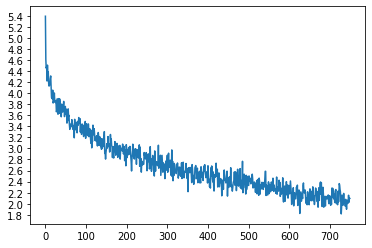

In [4]:
hidden_size = 256

encoder1 = EncoderRNN(input_question.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(
    hidden_size, output_question.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [5]:
evaluateRandomly(encoder1, attn_decoder1)

> how was the post it note invented ? 
= how were post it notes invented ? 
< how were the good from ? ? ?  <EOS>

> how s the world s population determined ? 
= how is the world s population estimated ? 
< is the the the world s ? ?  <EOS>

> who is a solutions architect ? 
= what is a solutions architect ? 
< what is a ? ?  <EOS>

> how does guys lose their virginity ? 
= how does a guy lose his virginity ? 
< how do i lose lose belly fat ?  <EOS>

> are dreams alternate realities ? 
= are dreams an alternate reality ? 
< are the illuminati real ?  <EOS>

> what is an electric drive ? 
= what is electric drive ? 
< what is a drive drive ?  <EOS>

> how do plane flaps work ? 
= how do airplane wing flaps work ? 
< how do lcd work ?  <EOS>

> how do you measure your success ? 
= how would you measure success ? 
< how do i change my success ?  <EOS>

> how to tackle npas ? 
= how do indian psbs recover npas ? 
< how do i get the ? ? ?  <EOS>

> is deadpool overrated ? 
= why is deadpool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')